# BigCorporation - Quarter strategy report

In this report, we analyse data related to movie reviews in order to derive insights and business values to help our company understand  users preferences and the kind of movies they enjoy the most in our platform. 

**Outline** 

1.   Exploratory data analysis for what we have achieved so far
      *   What is the number of users, movies, and ratings in our platform? How do they grow over time ?
      *   How is the ratings distribution ? and how does it look in respect to users age and gender ?

2.   A recommender engine to generate more profit 
      *   Building the recommender system
      *   How are we supposed to make money out of this ?
      *   How can we do it in a large scale ?


In [ ]:
# Importing necessary tools for our analysis
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import time
from tqdm import  tqdm
from IPython.display import clear_output
%matplotlib inline
sns.set()

In [ ]:
# Ignore annoying warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Run this cell to download the data and unzip it
!wget -q http://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip 

In [ ]:
# Reading the data
users = pd.read_table('./ml-1m/users.dat',sep='::',header = None)
ratings = pd.read_table('./ml-1m/ratings.dat',sep='::',header = None)
movies = pd.read_table('./ml-1m/movies.dat',sep='::',header = None)

# Naming the columns for better readability
users.columns = ['user_id','gender','age','occupation','zip']
ratings.columns = ['user_id','movie_id','rating','timestamp']
movies.columns = ['movie_id','title','genres']

In [ ]:
# Merging data and features preparation
ratings.timestamp = ratings.timestamp.apply(lambda x: datetime.fromtimestamp(x))
ratings = pd.merge(ratings, movies, on='movie_id', how='inner')
ratings = pd.merge(ratings, users, on='user_id', how='inner')
ratings['age_range'] = pd.cut(ratings.age, bins=3)

In [41]:
ratings.head()

,user_id,movie_id,rating,timestamp,title,genres,gender,age,occupation,zip,age_range
0,1,1193,5,2000-12-31 22:12:40,One Flew Over the Cuckoo's Nest (1975),Drama,F,1,10,48067,"(0.945, 19.333]"
1,1,661,3,2000-12-31 22:35:09,James and the Giant Peach (1996),Animation|Children's|Musical,F,1,10,48067,"(0.945, 19.333]"
2,1,914,3,2000-12-31 22:32:48,My Fair Lady (1964),Musical|Romance,F,1,10,48067,"(0.945, 19.333]"
3,1,3408,4,2000-12-31 22:04:35,Erin Brockovich (2000),Drama,F,1,10,48067,"(0.945, 19.333]"
4,1,2355,5,2001-01-06 23:38:11,"Bug's Life, A (1998)",Animation|Children's|Comedy,F,1,10,48067,"(0.945, 19.333]"


# Exploratory data analysis for what we have achieved so far
**What is the number of users, movies, and ratings in out platform? How do they grow over time ?**



In [ ]:
ratings['MonthYear'] = ratings.timestamp.apply(lambda x: f'{x.year}-{x.month}')

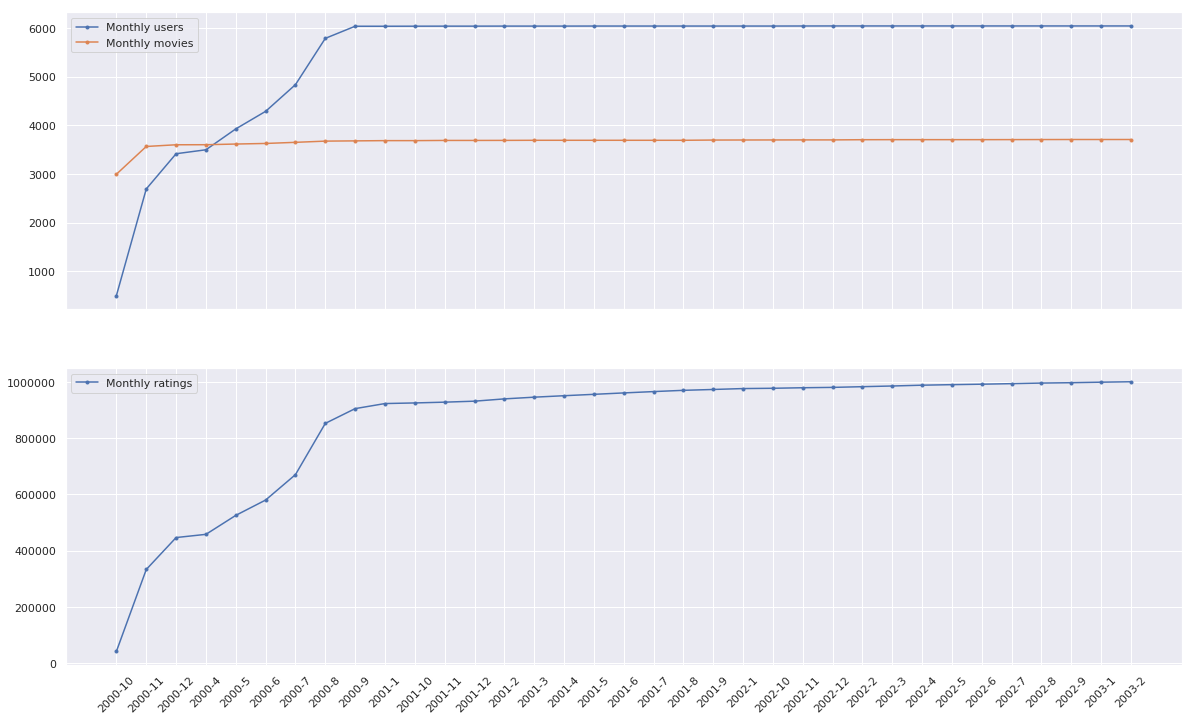

In [80]:
fig, axes = plt.subplots(2, 1 , figsize=(20,12), sharex=True)
months = ratings.MonthYear.sort_values().unique()
monthly_users = [ratings[ratings.MonthYear <= month].user_id.nunique() for month in tqdm(months)]
monthly_movies =  [ratings[ratings.MonthYear <= month].movie_id.nunique() for month in tqdm(months)]
monthly_ratings =  [len(ratings[ratings.MonthYear <= month]) for month in tqdm(months)]
clear_output()
axes[0].plot(months, monthly_users, label='Monthly users', marker='.')
axes[0].plot(months, monthly_movies, label='Monthly movies', marker='.')
axes[1].plot(months, monthly_ratings, label='Monthly ratings', marker='.')
plt.xticks(rotation=45)
axes[0].legend()
axes[1].legend()

We have reached 1 million ratings so far, however, we see that the number of users and movies stagnate in the previous months. 

**How is the ratings distribution ? and how does it look in respect to users age and gender ?**

First, let's visualize the distribution of rating for each movie genre to see if our users prefer any specific movie genres based on their gender and age.

In [ ]:
genres_unique_ = pd.DataFrame(movies.genres.str.split('|').tolist()).stack().unique()
genres_unique = pd.DataFrame(genres_unique_, columns=['genre']) 
movies = movies.join(movies.genres.str.get_dummies().astype(bool))
movies.drop('genres', inplace=True, axis=1)

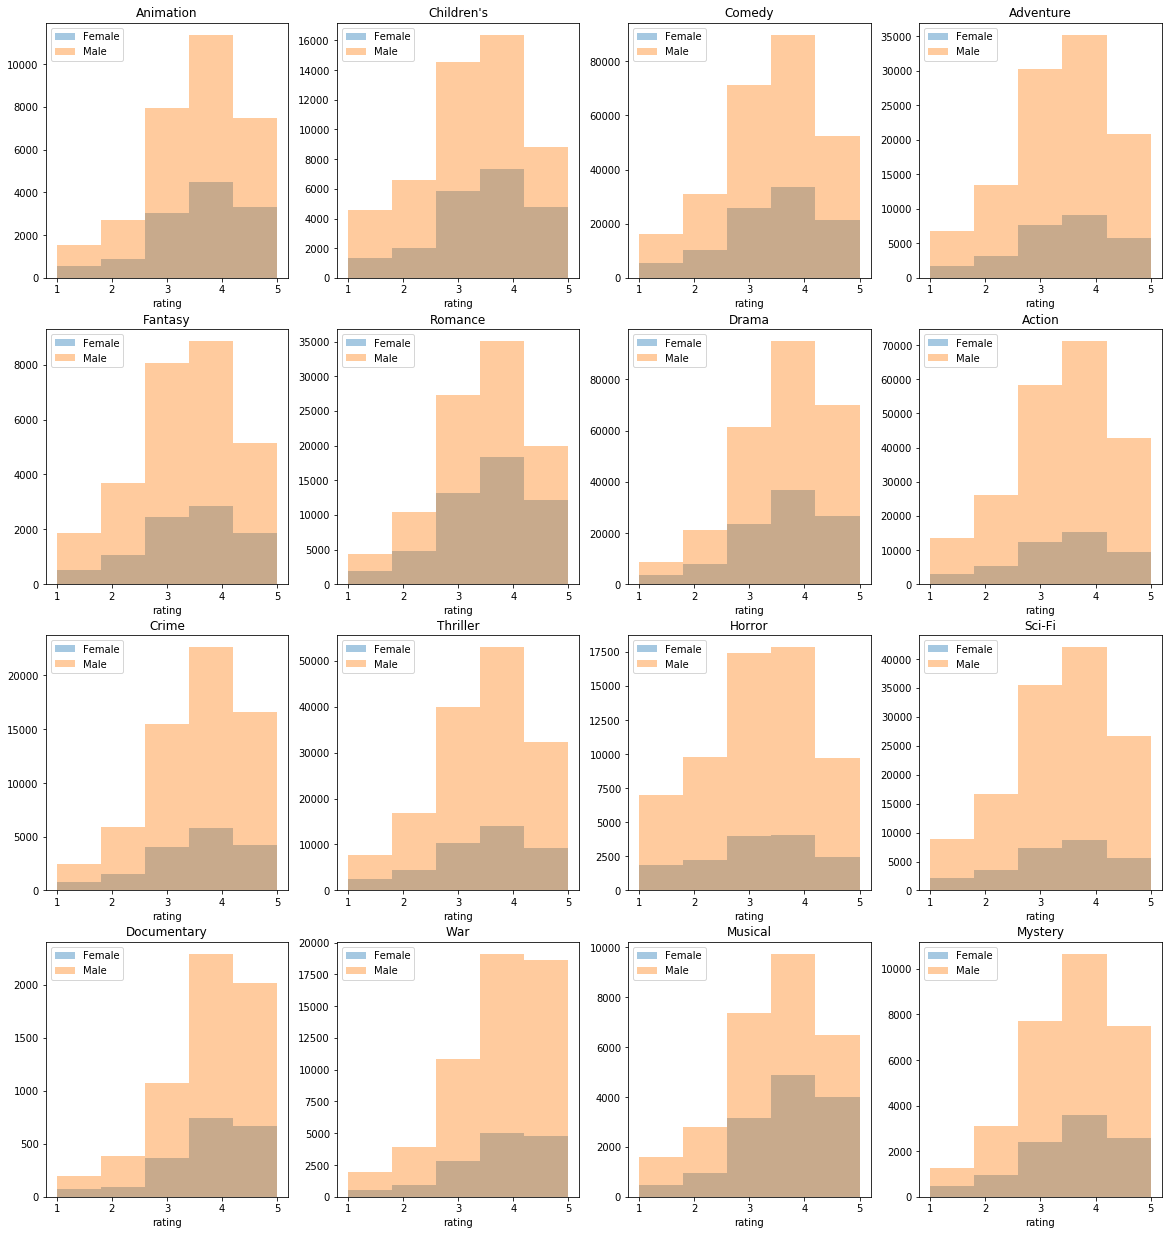

In [17]:
fig, axes = plt.subplots(len(genres_unique_) // 4, 4, figsize=(20, len(genres_unique_)*1.2))
for genre, ax in zip(genres_unique_, axes.flatten()):
    sns.distplot(ratings[ratings.movie_id.isin(movies[movies[genre]==True].movie_id.values) & (ratings.gender=='F')].rating, ax=ax, kde=False, bins=5, label='Female' )
    sns.distplot(ratings[ratings.movie_id.isin(movies[movies[genre]==True].movie_id.values) & (ratings.gender=='M')].rating, ax=ax, kde=False, bins=5, label='Male' )
    ax.set_title(genre)
    ax.legend()

Apparently, the dataset contains more rating from male than from female. We can see that the movie genre preferences are not based on users' gender. Both gender enjoy most genres. Users tend to watch Action, War and thriller movies more comparing to other genres.

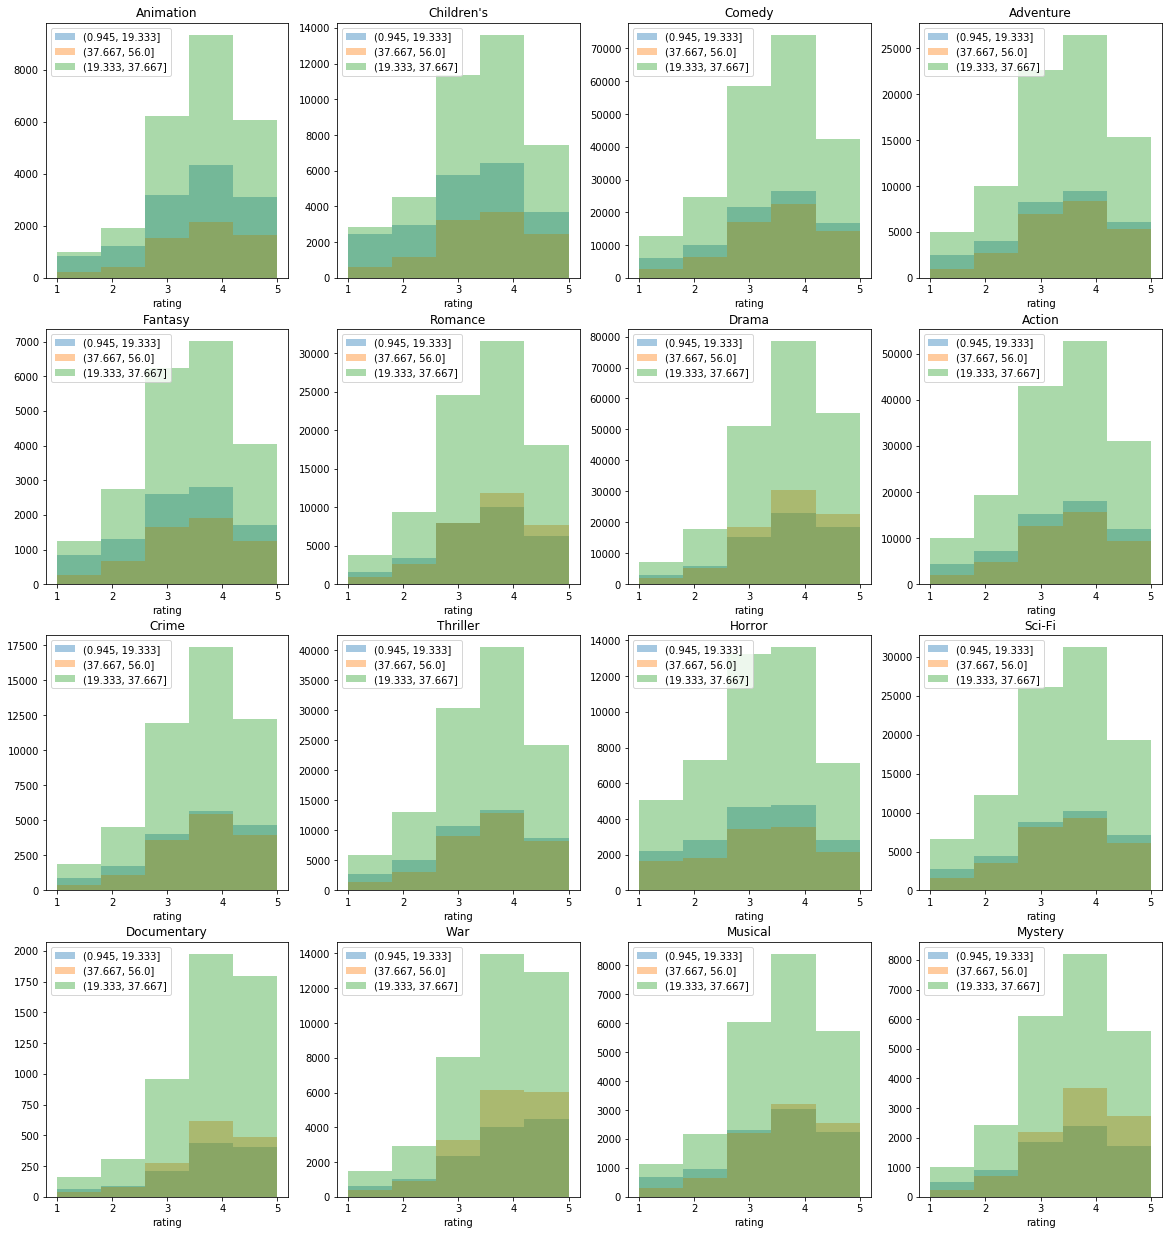

In [18]:
fig, axes = plt.subplots(len(genres_unique_) // 4, 4, figsize=(20, len(genres_unique_)*1.2))
for genre, ax in zip(genres_unique_, axes.flatten()):
    for age_r in ratings.age_range.unique():
        sns.distplot(ratings[ratings.movie_id.isin(movies[movies[genre]==True].movie_id.values) & (ratings.age_range==age_r)].rating, ax=ax, kde=False, bins=5, label=age_r)
    ax.set_title(genre)
    ax.legend()

We obsorve that most of our users belong to the young category, with an age between 20 and 40. They watch all kind of movies, but in general, they prefer war and documentary movies.
Teenagers with age between 0 and 20, normally prefer  animation and childrens movies. However, old people with age more than 40, they tend to like war and documentary movies.

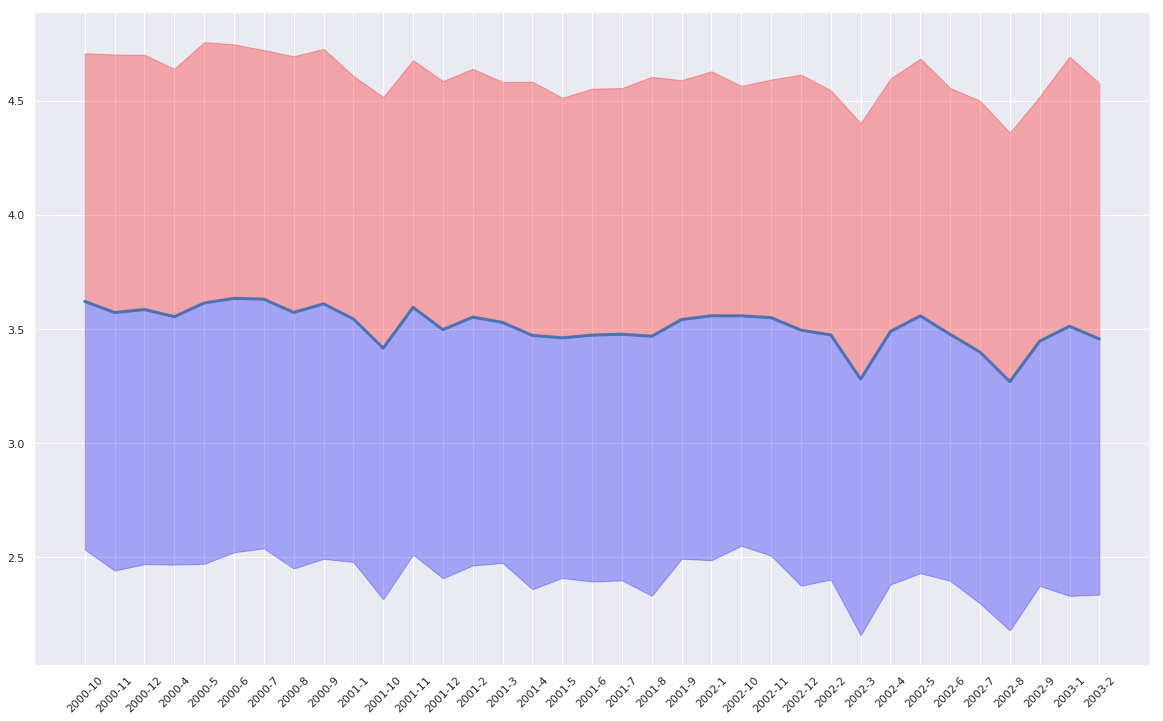

In [88]:
fig, ax = plt.subplots(1, 1 , figsize=(20,12), sharex=True)
monthly_mean_ratings = ratings.groupby('MonthYear').rating.mean().sort_index()
monthly_std_ratings = ratings.groupby('MonthYear').rating.std().sort_index()
ax.plot(months,monthly_mean_ratings, linewidth=3.0)
ax.fill_between(months,monthly_mean_ratings, monthly_mean_ratings + monthly_std_ratings, color="red", alpha=0.3)
ax.fill_between(months,monthly_mean_ratings, monthly_mean_ratings - monthly_std_ratings, color="blue", alpha=0.3)
plt.xticks(rotation=45);

The ratings are relatively consistent over time. 

# A recommender engine to generate more profit
## Building the recommender system

In this section we will build a recommendation engine to recommend movies for users based on their previous ratings. We will be using [PySpark's implementation for Collaborative filtering](https://spark.apache.org/docs/2.2.0/ml-collaborative-filtering.html), which used [alternating least squares (ALS)](http://dl.acm.org/citation.cfm?id=1608614) algorithm to learn users and movies related set of latent factors to predict users ratings for the movies they haven't seen before. 

First, we make sure we have java, pyspark are set up.

In [ ]:
!pip install pyspark

In [ ]:
!sudo apt install openjdk-8-jdk

In [ ]:
!sudo update-alternatives --config java

In [53]:
! java -version

openjdk version "1.8.0_222"
OpenJDK Runtime Environment (build 1.8.0_222-8u222-b10-1ubuntu1~18.04.1-b10)
OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)


We import the necessary modules from pyspark.

In [ ]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

In [ ]:
sc = SparkContext()
sql_sc = SQLContext(sc)

In [8]:
ratings.head()

,user_id,movie_id,rating,timestamp,title,genres,gender,age,occupation,zip,age_range
0,1,1193,5,2000-12-31 22:12:40,One Flew Over the Cuckoo's Nest (1975),Drama,F,1,10,48067,"(0.945, 19.333]"
1,1,661,3,2000-12-31 22:35:09,James and the Giant Peach (1996),Animation|Children's|Musical,F,1,10,48067,"(0.945, 19.333]"
2,1,914,3,2000-12-31 22:32:48,My Fair Lady (1964),Musical|Romance,F,1,10,48067,"(0.945, 19.333]"
3,1,3408,4,2000-12-31 22:04:35,Erin Brockovich (2000),Drama,F,1,10,48067,"(0.945, 19.333]"
4,1,2355,5,2001-01-06 23:38:11,"Bug's Life, A (1998)",Animation|Children's|Comedy,F,1,10,48067,"(0.945, 19.333]"


In [ ]:
ratingsRDD = sql_sc.createDataFrame(ratings[['movie_id','user_id','rating', 'title']])

We split our data into training and test sets

In [ ]:
training_df, validation_df, test_df = ratingsRDD.randomSplit([0.8, 0.2, 0.2])

In [20]:
training_df.cache()
validation_df.cache()
test_df.cache()

DataFrame[movie_id: bigint, user_id: bigint, rating: bigint, title: string]

In [12]:
training_df.show(5, truncate=False)


+--------+-------+------+----------------+
|movie_id|user_id|rating|title           |
+--------+-------+------+----------------+
|1       |1      |5     |Toy Story (1995)|
|1       |18     |4     |Toy Story (1995)|
|1       |19     |5     |Toy Story (1995)|
|1       |23     |4     |Toy Story (1995)|
|1       |44     |5     |Toy Story (1995)|
+--------+-------+------+----------------+
only showing top 5 rows



We instantiate ALS object for our recommender system as well as a regression evaluator to compute the RMSE on the test data.

In [ ]:
als = ALS(userCol="user_id", itemCol="movie_id", ratingCol="rating",
          coldStartStrategy="drop")

In [ ]:
reg_eval = RegressionEvaluator(predictionCol="prediction", labelCol="rating", metricName="rmse")

In [ ]:
errors = []
models = []

In [117]:
for rank in range(1, 11):
    als.setRank(rank)
    model =als.fit(training_df)
    predict_df = model.transform(validation_df)
    predicted_ratings_df = predict_df.filter(predict_df.prediction != float('nan'))
    error = reg_eval.evaluate(predicted_ratings_df)
    errors.append(error)
    models.append(model)
    
    print('Rank: %s  RMSE: %s' % (rank,error))
  

Rank: 1  RMSE: 0.9218221006375247
Rank: 2  RMSE: 0.8917073444129491
Rank: 3  RMSE: 0.8900619050487534
Rank: 4  RMSE: 0.8859485006158316
Rank: 5  RMSE: 0.8818760338802785
Rank: 6  RMSE: 0.8793635131175361
Rank: 7  RMSE: 0.8763174361759952
Rank: 8  RMSE: 0.8766452588280134
Rank: 9  RMSE: 0.8759378346808057
Rank: 10  RMSE: 0.8729464522997046


In [121]:
best_rank = np.argmin(errors)
print('Best model: %s' % best_rank)

Best model: 9


In [ ]:
best_model = models[best_rank]

We trained 10 ALS models to finetune the rank parameter, we pick the one with the smallest RMSE.

Let's predict the movies rating in the test set

In [ ]:
test_predict_df = best_model.transform(test_df)

In [110]:
test_predict_df.show(10)

+--------+-------+------+--------------------+----------+
|movie_id|user_id|rating|               title|prediction|
+--------+-------+------+--------------------+----------+
|     148|   3829|     2|Awfully Big Adven...| 2.5581563|
|     463|    970|     3|Guilty as Sin (1993)|   2.83826|
|     463|   3753|     2|Guilty as Sin (1993)|     2.465|
|     463|   3032|     4|Guilty as Sin (1993)|  4.271216|
|     463|   4510|     2|Guilty as Sin (1993)| 2.1317976|
|     463|   5795|     1|Guilty as Sin (1993)| 1.8559471|
|     463|    331|     4|Guilty as Sin (1993)|  2.239513|
|     463|    524|     3|Guilty as Sin (1993)|  2.145557|
|     463|   1962|     3|Guilty as Sin (1993)| 2.0203817|
|     463|   5831|     4|Guilty as Sin (1993)|  2.828741|
+--------+-------+------+--------------------+----------+
only showing top 10 rows



In [ ]:
test_predict_df = test_predict_df.filter(test_predict_df.prediction != float('nan'))

In [122]:
test_RMSE = reg_eval.evaluate(test_predict_df)
print('RMSE on test set: {0}'.format(test_RMSE))

RMSE on test set: 0.8715269931098151


We got a pretty good model so far, with relatively good generalisation. We are able to predict the user's rating for a specific movies with an error of 0.8 on average.

In [ ]:
test_predict_dfPd = test_predict_df.toPandas()

In [ ]:
test_predict_dfPd['prediction_rating'] = np.floor(test_predict_dfPd.prediction)

## How are we supposed to make money out of this ?

We have a recommender system ready to predict users' ratings, the idea is that we will be recommending movies with high prediction values to the corresponding users.

It's difficult to quantify the value of those recommendations, but we can simply put it as follow :


*Situation 1* :  we predict that a user will like a movie, and will give a rating greater or equal to 3. if we are right, we save 1€ otherwise we lose 1€.

*Situation 2*: we predict that a user will not be satisfied with a movie and will give a rating less or equal to 2. If we are right , we have nothing to lose, otherwise we lose 1$.

The aim is to estimate the cost we will save if we recommend accurate movies to users in the test dataset. 







In [ ]:
def prediction_cost(x):
    if (x.rating <= 2) :
        if (x.prediction_rating <= 2):
              return 0
        else:
              return -1
    else:
        if (x.prediction_rating > 2):
              return 1
        else:
              return -1

In [ ]:
test_predict_dfPd['cost'] = test_predict_dfPd.apply(lambda x : prediction_cost(x), axis=1)

In [133]:
print('Total saved cost  : €', test_predict_dfPd.cost.sum())

Total saved cost  : € 87328


We will be saving € 87328 if we have a recommender system in place to recommend movies to our users.
In general, the recommender system will contribute to the following business values to our company:
    * It provides great experience to our users in our platform.
    * It prevents users from churing and moving to other competitor platforms.
    * It saves a lot of money lost due to users churning.

## How can we do it in a large scale ?

There are plenty of large scale recommender system solutions. As we are an inoovative and ambitious company, we present a large scale, cost effective and highly available solution built on AWS.

![architecture](large-scale-recommender-system-architecture.PNG)

Source : https://www.slideshare.net/AmazonWebServices/building-a-recommender-system-on-aws

Few notes about the proposed architecture :
    * We use SageMaker Notebooks to prepare and clean our ratings data and store it in S3 buckets.
    * We train a recommender model and optimize it using SageMaker built-in Factorization Machines Algorithm.
    * We deploy our model to an endpoint and build an API to receive inference requests.